Missing values in each column before processing:
Date                              0
Hour                              0
Discharge Rate (cumecs)          11
Rainfall Data (mm)              122
Water Level (m)                  23
Next 1 Hour Water Level (m)      28
Next 2 Hours Water Level (m)     33
Next 3 Hours Water Level (m)     38
dtype: int64
Missing values in each column after processing:
Date                            0
Hour                            0
Discharge Rate (cumecs)         0
Rainfall Data (mm)              0
Water Level (m)                 0
Next 1 Hour Water Level (m)     0
Next 2 Hours Water Level (m)    0
Next 3 Hours Water Level (m)    0
dtype: int64
Training set size: 3612
Validation set size: 774
Testing set size: 774


C:\Users\Janith\AppData\Local\Temp\ipykernel_8288\2445381721.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)



Testing Results:
1st Hour Prediction Accuracy: 95.99%, MAE: 0.0823
2nd Hour Prediction Accuracy: 92.63%, MAE: 0.1547
3rd Hour Prediction Accuracy: 89.48%, MAE: 0.2184

Sample Predictions vs Actual Values:
   Actual 1st Hour  Predicted 1st Hour  Actual 2nd Hour  Predicted 2nd Hour  \
0             0.15            0.129957             0.17            0.133381   
1             0.77            0.768790             0.82            0.781510   
2             2.71            2.705375             2.81            2.742000   
3             1.80            1.900043             1.70            1.910890   
4             2.23            2.305231             2.18            2.290156   
5             0.26            0.258782             0.25            0.265775   
6             1.22            1.208855             1.22            1.194723   
7             3.34            3.363900             3.41            3.417817   
8             0.23            0.237903             0.22            0.232733   
9   

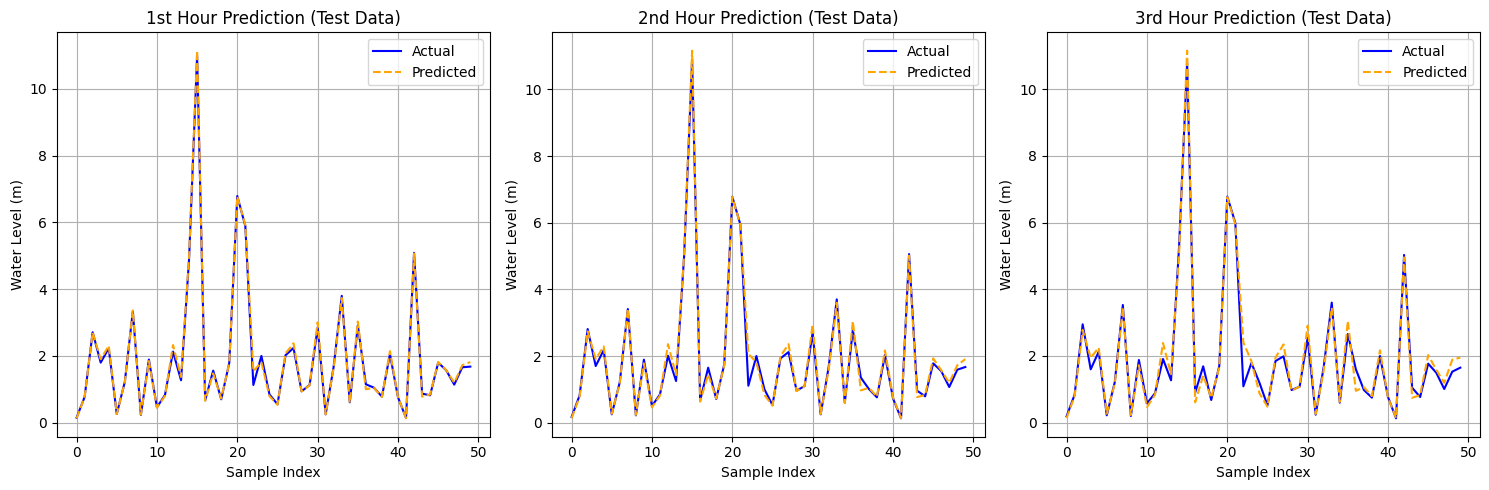

In [14]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Load the dataset
file_path = "F:/FYP project/FYP(Flood)/Real Data/Flood_fyp_data.csv"  # Replace with your file path
data = pd.read_csv(file_path)

# Check for null values
print("Missing values in each column before processing:")
print(data.isnull().sum())

# Method 1: Handle NaN values using forward-fill
data.fillna(method='ffill', inplace=True)

# Method 2: Interpolation (optional, if you want to interpolate instead of forward fill)
#data.interpolate(method='linear', inplace=True)

# Recheck for null values after filling
print("Missing values in each column after processing:")
print(data.isnull().sum())

# Drop 'Date' and 'Hour' columns
data = data.drop(columns=['Date', 'Hour'], errors='ignore')

# Define input features (X) and target values (y)
X = data[['Discharge Rate (cumecs)', 'Rainfall Data (mm)', 'Water Level (m)']].values
y = data[['Next 1 Hour Water Level (m)', 'Next 2 Hours Water Level (m)', 'Next 3 Hours Water Level (m)']].values

# Normalize the input features
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)

# Split dataset into training (70%), validation (15%), and testing (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

# Initialize and train the Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_test_pred = model.predict(X_test)

# Function to calculate accuracy as a percentage
def calculate_accuracy(y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # MAPE in percentage
    accuracy = 100 - mape  # Accuracy in percentage
    return accuracy

# Calculate accuracy and MAE for each hour
accuracy_1st_hour = calculate_accuracy(y_test[:, 0], y_test_pred[:, 0])
mae_1st_hour = mean_absolute_error(y_test[:, 0], y_test_pred[:, 0])

accuracy_2nd_hour = calculate_accuracy(y_test[:, 1], y_test_pred[:, 1])
mae_2nd_hour = mean_absolute_error(y_test[:, 1], y_test_pred[:, 1])

accuracy_3rd_hour = calculate_accuracy(y_test[:, 2], y_test_pred[:, 2])
mae_3rd_hour = mean_absolute_error(y_test[:, 2], y_test_pred[:, 2])

# Print accuracies and MAE
print("\nTesting Results:")
print(f"1st Hour Prediction Accuracy: {accuracy_1st_hour:.2f}%, MAE: {mae_1st_hour:.4f}")
print(f"2nd Hour Prediction Accuracy: {accuracy_2nd_hour:.2f}%, MAE: {mae_2nd_hour:.4f}")
print(f"3rd Hour Prediction Accuracy: {accuracy_3rd_hour:.2f}%, MAE: {mae_3rd_hour:.4f}")

## Calculate accuracy for each hour
#accuracy_1st_hour = calculate_accuracy(y_test[:, 0], y_test_pred[:, 0])
#accuracy_2nd_hour = calculate_accuracy(y_test[:, 1], y_test_pred[:, 1])
#accuracy_3rd_hour = calculate_accuracy(y_test[:, 2], y_test_pred[:, 2])
#
## Print accuracies
#print("\nTesting Accuracy:")
#print(f"1st Hour Prediction Accuracy: {accuracy_1st_hour:.2f}%")
#print(f"2nd Hour Prediction Accuracy: {accuracy_2nd_hour:.2f}%")
#print(f"3rd Hour Prediction Accuracy: {accuracy_3rd_hour:.2f}%")

# Display some sample predictions vs actual values
print("\nSample Predictions vs Actual Values:")
sample_data = pd.DataFrame({
    'Actual 1st Hour': y_test[:, 0],
    'Predicted 1st Hour': y_test_pred[:, 0],
    'Actual 2nd Hour': y_test[:, 1],
    'Predicted 2nd Hour': y_test_pred[:, 1],
    'Actual 3rd Hour': y_test[:, 2],
    'Predicted 3rd Hour': y_test_pred[:, 2],
})
print(sample_data.head(10))

# Visualization: True vs Predicted values for all 3 targets
plt.figure(figsize=(15, 5))
for i, target in enumerate(['1st Hour', '2nd Hour', '3rd Hour']):
    plt.subplot(1, 3, i+1)
    plt.plot(y_test[:50, i], label='Actual', color='blue')
    plt.plot(y_test_pred[:50, i], label='Predicted', color='orange', linestyle='--')
    plt.title(f'{target} Prediction (Test Data)')
    plt.xlabel('Sample Index')
    plt.ylabel('Water Level (m)')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()


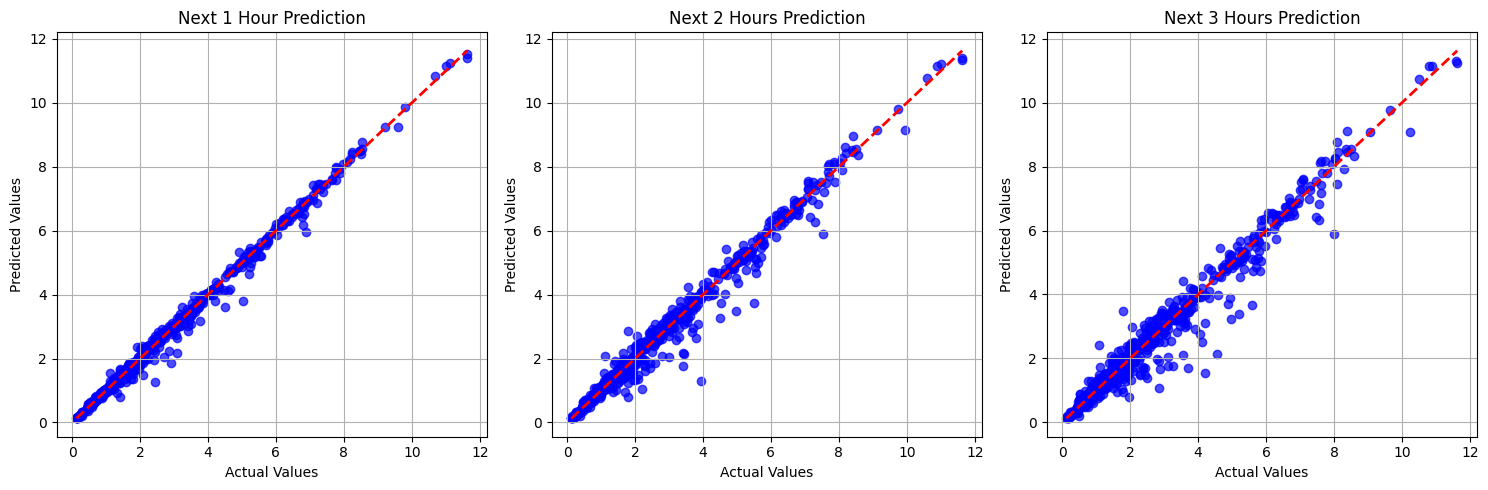

In [12]:
# Visualization: True vs Predicted values for all 3 targets
plt.figure(figsize=(15, 5))
for i, target in enumerate(['Next 1 Hour', 'Next 2 Hours', 'Next 3 Hours']):
    plt.subplot(1, 3, i+1)
    plt.scatter(y_test[:, i], y_test_pred[:, i], alpha=0.7, color='blue')
    plt.plot([min(y_test[:, i]), max(y_test[:, i])], 
             [min(y_test[:, i]), max(y_test[:, i])], 
             color='red', linestyle='--', linewidth=2)  # Ideal line
    plt.title(f'{target} Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)
plt.tight_layout()
plt.show()